In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow Hub


[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

This tutorial demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`
1. Use an image classification model from TensorFlow Hub
1. Do simple transfer learning to fine-tune a model for your own image classes

## Setup

In [2]:
import numpy as np

import PIL.Image as Image
import matplotlib.pylab as plt
import os
import tensorflow as tf
import tensorflow_hub as hub

## Simple transfer learning

But what if you want to train a classifier for a dataset with different classes? You can also use a model from TFHub to train a custom image classier by retraining the top layer of the model to recognize the classes in our dataset.

### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [3]:
home_dir = os.getcwd()
data_dir = os.path.join(home_dir, 'Data')
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')
export_dir = os.path.join(data_dir, 'Model')

print(train_dir)

/home/richard/Data/Train


In [4]:
# Set memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Let's load this data into our model using  images off disk using image_dataset_from_directory.

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                                    validation_split=0.2,
                                                                    subset="training",
                                                                    seed=123,
                                                                    batch_size=BATCH_SIZE, 
                                                                    image_size=IMG_SIZE)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                                    validation_split=0.2,
                                                                    subset="validation",
                                                                    seed=123,
                                                                    batch_size=BATCH_SIZE, 
                                                                    image_size=IMG_SIZE)

class_names = np.array(train_dataset.class_names)
print(class_names)

Found 1600 files belonging to 2 classes.
Using 1280 files for training.
Found 1600 files belonging to 2 classes.
Using 320 files for validation.
['Dirt' 'Scratch']


TensorFlow Hub's conventions for image models is to expect float inputs in the `[0, 1]` range. Use the `Rescaling` layer to achieve this.

Note: you could also include the `Rescaling` layer inside the model. See this [guide](https://www.tensorflow.org/guide/keras/preprocessing_layers) for a discussion of the tradeoffs.

In [6]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


# Run the original classifier on a batch of images

### Download the classifier

Use `hub.KerasLayer` to load a [MobileNetV2 model](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) from TensorFlow Hub. Any [compatible image classifier model](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

Now check how these predictions line up with the images:

['velvet' 'wall clock' 'envelope' ... 'shower curtain' 'nematode' 'velvet']


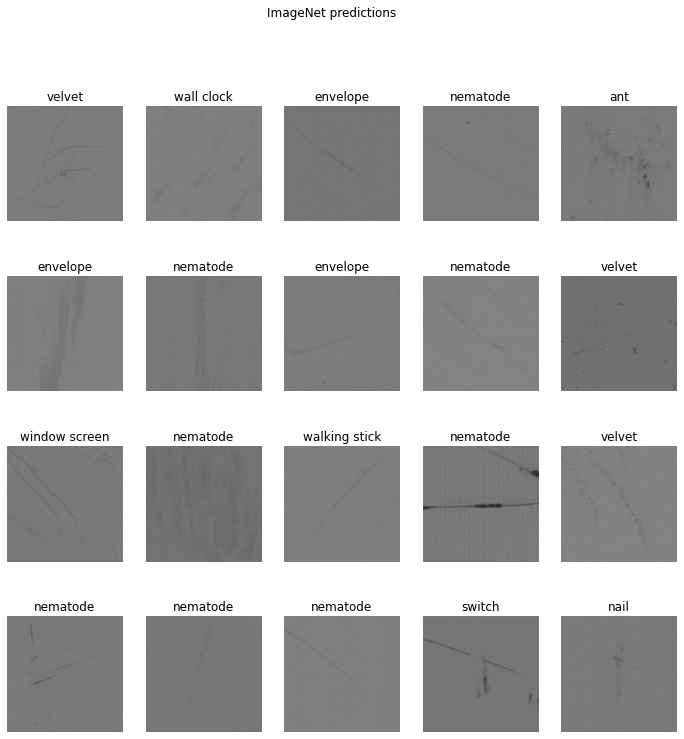

In [9]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" #@param {type:"string"}

IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))])
result_batch = classifier.predict(train_dataset)

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
print(predicted_class_names)

plt.figure(figsize=(12,12))
for n in range(20):
    plt.subplot(4,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [compatible image feature vector model](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [10]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

Create the feature extractor. Use `trainable=False` to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [11]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

It returns a 1280-length vector for each image:

In [12]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [13]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
predictions = model(image_batch)

In [15]:
predictions.shape

TensorShape([32, 2])

### Train the model

Use compile to configure the training process:

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [17]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()


history = model.fit(train_dataset               
                    ,validation_data=validation_dataset, epochs=10, callbacks=[batch_stats_callback])

Epoch 1/10
40/40 [==============================] - 3s 40ms/step - loss: 0.2810 - accuracy: 0.8438 - val_loss: 0.1441 - val_accuracy: 0.9719
Epoch 2/10
40/40 [==============================] - 1s 31ms/step - loss: 0.2050 - accuracy: 0.9062 - val_loss: 0.1067 - val_accuracy: 0.9719
Epoch 3/10
40/40 [==============================] - 1s 32ms/step - loss: 0.1729 - accuracy: 0.9375 - val_loss: 0.0967 - val_accuracy: 0.9750
Epoch 4/10
40/40 [==============================] - 1s 32ms/step - loss: 0.1503 - accuracy: 0.9375 - val_loss: 0.0908 - val_accuracy: 0.9812
Epoch 5/10
40/40 [==============================] - 1s 31ms/step - loss: 0.1331 - accuracy: 0.9375 - val_loss: 0.0871 - val_accuracy: 0.9781
Epoch 6/10
40/40 [==============================] - 1s 32ms/step - loss: 0.1193 - accuracy: 0.9375 - val_loss: 0.0847 - val_accuracy: 0.9781
Epoch 7/10
40/40 [==============================] - 1s 31ms/step - loss: 0.1080 - accuracy: 0.9688 - val_loss: 0.0831 - val_accuracy: 0.9750
Epoch 8/10
40

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

### Learning curves

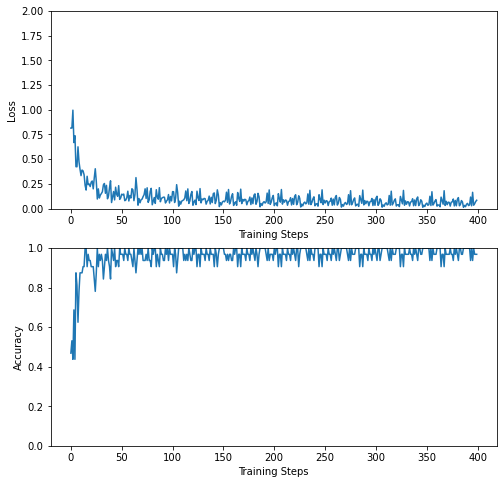

In [18]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.subplot(2,1,2)
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [19]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

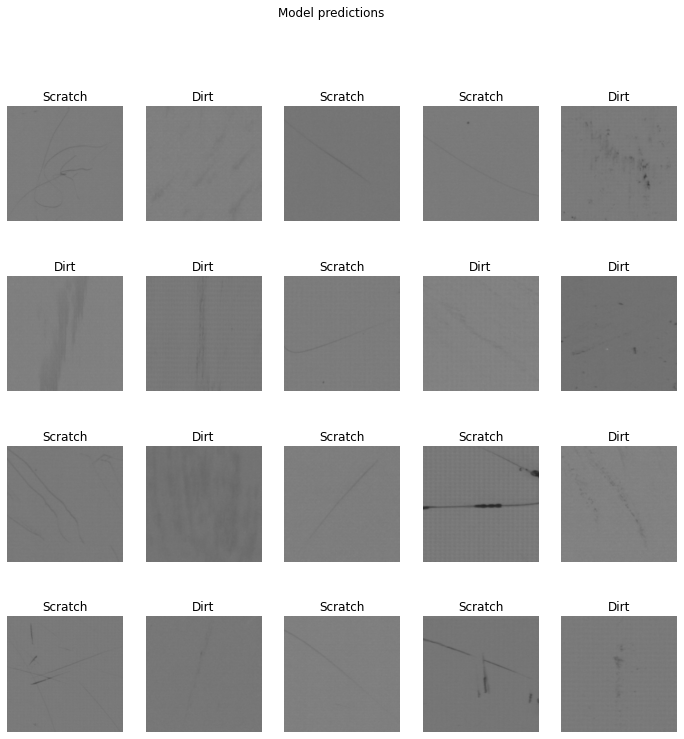

In [20]:
plt.figure(figsize=(12,12))
for n in range(20):
    plt.subplot(4, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")